Размеры выборок: Train (88, 5), Val (19, 5), Test (20, 5)
Целевая переменная: weekend_study

KNN: Лучший k = 9 (Accuracy на val: 0.84)
LogReg: Лучший порог = 0.10 (F1 на val: 0.91)


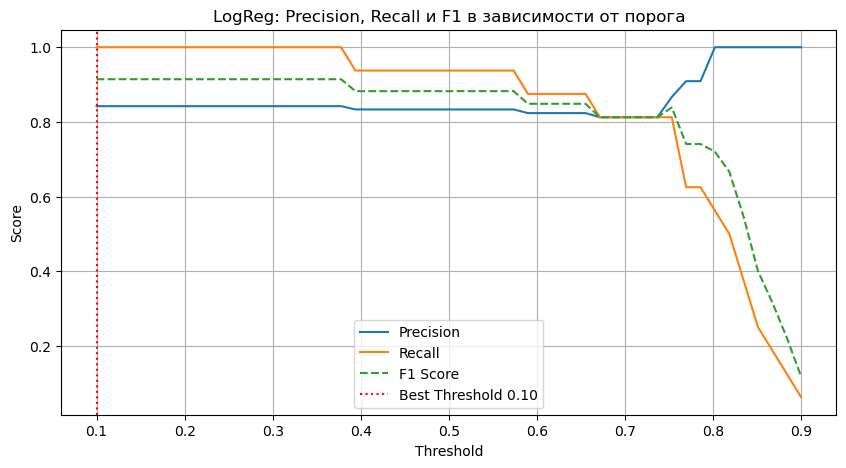


--- РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ ---

Модель: 0. Trivial
Accuracy: 0.85
Precision: 0.85
Recall:   1.00
ROC-AUC:  0.50
Матрица ошибок:
[[ 0  3]
 [ 0 17]]

Модель: 1. Naive Bayes
Accuracy: 0.80
Precision: 0.84
Recall:   0.94
ROC-AUC:  0.47
Матрица ошибок:
[[ 0  3]
 [ 1 16]]

Модель: 2. KNN (k=9)
Accuracy: 0.85
Precision: 0.85
Recall:   1.00
ROC-AUC:  0.50
Матрица ошибок:
[[ 0  3]
 [ 0 17]]

Модель: 3. LogReg (t=0.10)
Accuracy: 0.85
Precision: 0.85
Recall:   1.00
ROC-AUC:  0.92
Матрица ошибок:
[[ 0  3]
 [ 0 17]]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. ЗАГРУЗКА И ПРЕДОБРАБОТКА ДАННЫХ
# ==========================================

# Загрузка
df = pd.read_csv('famcs_students.csv')

# Определение целевой переменной (N=10 -> index 2 -> weekend_study)
target_col = 'weekend_study'

# Преобразование целевой переменной в бинарный формат (Да=1, Нет=0)
# Проверим значения в столбце, чтобы корректно сделать маппинг
df[target_col] = df[target_col].map({'Да': 1, 'Нет': 0})

# Выбор признаков (X). Выберем 5 информативных признаков.
# Для простоты реализации алгоритмов (особенно KNN и LogReg) используем численные признаки
# и преобразуем категориальный 'sex'.
df['sex_num'] = df['sex'].map({'М': 1, 'Ж': 0})

feature_cols = ['score', 'miss', 'height', 'age', 'sex_num']

# Удаление строк с пропусками в выбранных колонках
data = df[feature_cols + [target_col]].dropna()

X = data[feature_cols].values
y = data[target_col].values

# Стандартизация данных (обязательно для KNN и LogReg!)
# Z-score normalization: (x - mean) / std
mean = X.mean(axis=0)
std = X.std(axis=0)
X_scaled = (X - mean) / std

# Разделение на выборки: Train (70%), Val (15%), Test (15%)
np.random.seed(42)
indices = np.random.permutation(len(X))
n = len(X)
n_train = int(0.7 * n)
n_val = int(0.15 * n)

idx_train = indices[:n_train]
idx_val = indices[n_train:n_train + n_val]
idx_test = indices[n_train + n_val:]

X_train, y_train = X_scaled[idx_train], y[idx_train]
X_val, y_val = X_scaled[idx_val], y[idx_val]
X_test, y_test = X_scaled[idx_test], y[idx_test]

print(f"Размеры выборок: Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")
print(f"Целевая переменная: {target_col}")

# ==========================================
# ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ МЕТРИК
# ==========================================
def get_metrics(y_true, y_pred, y_prob=None):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Упрощенный ROC-AUC (просто возвращаем метрику, для полноценного расчета нужен sklearn)
    # Здесь вернем Accuracy как заглушку, если не подключать sklearn
    roc_auc = "N/A (нужен sklearn)" 
    
    return {"acc": accuracy, "prec": precision, "rec": recall, "f1": f1, "matrix": [[tn, fp], [fn, tp]]}

# ==========================================
# 0. ТРИВИАЛЬНЫЙ КЛАССИФИКАТОР
# ==========================================
class TrivialModel:
    def fit(self, y):
        counts = np.bincount(y.astype(int))
        self.mode = np.argmax(counts)
    
    def predict(self, X):
        return np.full(X.shape[0], self.mode)

# ==========================================
# 1. НАИВНЫЙ БАЙЕСОВСКИЙ (Gaussian NB)
# ==========================================
class MyNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.params = {}
        for c in self.classes:
            X_c = X[y == c]
            self.params[c] = {
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0) + 1e-9, # добавляем epsilon для стабильности
                'prior': len(X_c) / len(X)
            }
            
    def _pdf(self, class_idx, x):
        mean = self.params[class_idx]['mean']
        var = self.params[class_idx]['var']
        numerator = np.exp(- (x - mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.params[c]['prior'])
                # Сумма логарифмов правдоподобия (log-likelihood)
                conditional = np.sum(np.log(self._pdf(c, x)))
                posteriors.append(prior + conditional)
            y_pred.append(self.classes[np.argmax(posteriors)])
        return np.array(y_pred)

# ==========================================
# 2. МЕТОД K-БЛИЖАЙШИХ СОСЕДЕЙ (KNN)
# ==========================================
class MyKNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = []
        for x in X:
            # Евклидово расстояние
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            # Индексы k ближайших
            k_indices = np.argsort(distances)[:self.k]
            # Голоса
            k_nearest_labels = self.y_train[k_indices]
            # Мажоритарное голосование
            counts = np.bincount(k_nearest_labels.astype(int))
            y_pred.append(np.argmax(counts))
        return np.array(y_pred)

# Подбор K по валидационной выборке
best_k = 1
best_acc = 0
for k in range(1, 15):
    knn = MyKNN(k=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_val)
    acc = np.mean(preds == y_val)
    if acc > best_acc:
        best_acc = acc
        best_k = k
print(f"\nKNN: Лучший k = {best_k} (Accuracy на val: {best_acc:.2f})")

# ==========================================
# 3. ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ
# ==========================================
class MyLogReg:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.threshold = 0.5

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Градиентный спуск
        for _ in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X):
        y_predicted_cls = [1 if i > self.threshold else 0 for i in self.predict_proba(X)]
        return np.array(y_predicted_cls)

# Обучение LogReg
log_reg = MyLogReg(lr=0.1, epochs=3000)
log_reg.fit(X_train, y_train)
probs_val = log_reg.predict_proba(X_val)

# Подбор порога (Threshold Tuning)
thresholds = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []
f1_scores = []

best_thresh = 0.5
max_f1 = 0

for t in thresholds:
    preds_t = (probs_val >= t).astype(int)
    m = get_metrics(y_val, preds_t)
    precisions.append(m['prec'])
    recalls.append(m['rec'])
    f1_scores.append(m['f1'])
    if m['f1'] > max_f1:
        max_f1 = m['f1']
        best_thresh = t

print(f"LogReg: Лучший порог = {best_thresh:.2f} (F1 на val: {max_f1:.2f})")
log_reg.threshold = best_thresh

# График Precision/Recall от порога
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score', linestyle='--')
plt.axvline(best_thresh, color='red', linestyle=':', label=f'Best Threshold {best_thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('LogReg: Precision, Recall и F1 в зависимости от порога')
plt.legend()
plt.grid(True)
plt.show()

# ==========================================
# 4. ИТОГОВАЯ ОЦЕНКА (TEST SET)
# ==========================================
from sklearn.metrics import roc_auc_score # Импортируем только для финального сложного скора

models = {
    "0. Trivial": TrivialModel(),
    f"1. Naive Bayes": MyNaiveBayes(),
    f"2. KNN (k={best_k})": MyKNN(k=best_k),
    f"3. LogReg (t={best_thresh:.2f})": log_reg
}

# Обучаем заново KNN (он не хранит веса) и NB, LogReg уже обучен
models["0. Trivial"].fit(y_train)
models["1. Naive Bayes"].fit(X_train, y_train)
models[f"2. KNN (k={best_k})"].fit(X_train, y_train)

print("\n--- РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ ---")
results = []
for name, model in models.items():
    preds = model.predict(X_test)
    m = get_metrics(y_test, preds)
    
    # Расчет ROC-AUC (требует вероятностей, для простых моделей берем предсказания)
    try:
        if hasattr(model, 'predict_proba'):
            probs = model.predict_proba(X_test)
            auc = roc_auc_score(y_test, probs)
        else:
            auc = roc_auc_score(y_test, preds)
    except:
        auc = 0.5
        
    print(f"\nМодель: {name}")
    print(f"Accuracy: {m['acc']:.2f}")
    print(f"Precision: {m['prec']:.2f}")
    print(f"Recall:   {m['rec']:.2f}")
    print(f"ROC-AUC:  {auc:.2f}")
    print(f"Матрица ошибок:\n{np.array(m['matrix'])}")